<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Parameters" data-toc-modified-id="Parameters-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></span><ul class="toc-item"><li><span><a href="#Filter-low-coverage" data-toc-modified-id="Filter-low-coverage-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Filter low coverage</a></span></li></ul></li><li><span><a href="#Set-CPU" data-toc-modified-id="Set-CPU-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Set CPU</a></span><ul class="toc-item"><li><span><a href="#Prepare-BSseq-input" data-toc-modified-id="Prepare-BSseq-input-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Prepare BSseq input</a></span></li></ul></li><li><span><a href="#Create-BSseq-object" data-toc-modified-id="Create-BSseq-object-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Create BSseq object</a></span><ul class="toc-item"><li><span><a href="#Add-experiment-design" data-toc-modified-id="Add-experiment-design-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Add experiment design</a></span></li></ul></li><li><span><a href="#Run-dmrseq" data-toc-modified-id="Run-dmrseq-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Run dmrseq</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
from pysam import TabixFile
import rpy2
import pathlib
from rpy2.robjects.vectors import IntVector
from rpy2.robjects import r, pandas2ri, numpy2ri
pandas2ri.activate()
numpy2ri.activate()
%load_ext rpy2.ipython

In [2]:
%%R
library(dmrseq)

R[write to console]: Loading required package: bsseq

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, t

## Parameters

In [3]:
allc_table_path = '2000.allc_table.tsv'
region = 'chr1:0-5000000'

# variables
testCovariate = 'group'
matchCovariate = None
adjustCovariate = None

# DMR Parameters
cutoff = 0.1
minNumRegion = 3
smooth = True
bpSpan = 1000
minInSpan = 30
maxGapSmooth = 2500
maxGap = 1000
verbose = True
maxPerms = 10
stat = "stat"
block = False
blockSize = 5000
chrsPerChunk = 1

# Parallel
cpu = 40

In [4]:
# rpy2 can not convert None
if (matchCovariate is None) or (len(matchCovariate) == 0):
    matchCovariate = []
if (adjustCovariate is None) or (len(adjustCovariate) == 0):
    adjustCovariate = []

## Load data

In [5]:
allc_table = pd.read_csv(allc_table_path, sep='\t')
allc_table

,allc_path,sample,group
0,/gale/netapp/home/hanliu/scratch/DMR_benchmark...,DG_2000_0,DG
1,/gale/netapp/home/hanliu/scratch/DMR_benchmark...,DG_2000_1,DG
2,/gale/netapp/home/hanliu/scratch/DMR_benchmark...,DG_2000_2,DG
3,/gale/netapp/home/hanliu/scratch/DMR_benchmark...,IT-L23_2000_0,IT-L23
4,/gale/netapp/home/hanliu/scratch/DMR_benchmark...,IT-L23_2000_1,IT-L23
5,/gale/netapp/home/hanliu/scratch/DMR_benchmark...,IT-L23_2000_2,IT-L23


In [6]:
# reformat allc to dss required format
def get_data(allc_table):
    dfs = []
    for _, (input_path, sample, *_) in allc_table.iterrows():
        records = []
        with TabixFile(str(input_path)) as f:
            for line in f.fetch(region):
                chromosome, pos, _, _, mc, cov, _ = (line.split('\t'))
                records.append([chromosome, int(pos), int(mc), int(cov)])
        dfs.append(
            pd.DataFrame(
                records,
                columns=['chr', 'pos', f'{sample}_mc',
                         f'{sample}_cov']).set_index(['chr', 'pos']))
    return dfs


mc_dfs = get_data(allc_table)
sample_order = allc_table['sample'].values
total_data = pd.concat(mc_dfs, axis=1, sort=True).fillna(0).astype(int)

### Filter low coverage

In [7]:
judges = []
for group, sub_df in allc_table.groupby(testCovariate):
    group_judge = total_data.loc[:,
                                 [f'{s}_cov'
                                  for s in sub_df['sample']]].sum(axis=1) > 0
    judges.append(group_judge)
# all the group must > 0
judges = np.all(judges, axis=0)

In [8]:
print(
    f'Got {judges.size} loci, {judges.sum()} passed minimum coverage requirement by dmrseq'
)

# The R parallel function uses a lot of memory in the qsub system.
# Parallel on region level with single core in R is overall more efficient.
cpu = 1
print(f'Using {cpu} CPUs')

Got 22586 loci, 22358 passed minimum coverage requirement by dmrseq
Using 1 CPUs


## Set CPU

In [9]:
%%R -i cpu
library("BiocParallel")
register(MulticoreParam(cpu))

### Prepare BSseq input

In [10]:
mc_data = total_data.loc[judges, [f'{s}_mc' for s in sample_order]].values
cov_data = total_data.loc[judges, [f'{s}_cov' for s in sample_order]].values
chroms = total_data.loc[judges].index.get_level_values(0).values
posision = total_data.loc[judges].index.get_level_values(1).values

# remove allc_path column and use sample as index
exp_design = allc_table.iloc[:, 1:].set_index('sample')

## Create BSseq object

In [11]:
%%R -i chroms -i posision -i mc_data -i cov_data -i sample_order
bs <- BSseq(chr=chroms,
            pos=posision,
            M=mc_data,
            Cov=cov_data,
            sampleNames=sample_order)
bs

An object of type 'BSseq' with
  22358 methylation loci
  6 samples
has not been smoothed
All assays are in-memory


### Add experiment design

In [12]:
%%R -i exp_design
pData(bs) <- exp_design
pData(bs)

DataFrame with 6 rows and 1 column
                    group
              <character>
DG_2000_0              DG
DG_2000_1              DG
DG_2000_2              DG
IT-L23_2000_0      IT-L23
IT-L23_2000_1      IT-L23
IT-L23_2000_2      IT-L23


## Run dmrseq

In [13]:
%%R -i testCovariate -i adjustCovariate -i matchCovariate -i cutoff -i minNumRegion -i smooth -i bpSpan -i minInSpan -i maxGapSmooth -i maxGap -i verbose -i maxPerms -i stat -i block -i blockSize -i chrsPerChunk -o regions_df

# If input is empty list, turn it into NULL
if (length(adjustCovariate) == 0) {
    adjustCovariate <- NULL
}
if (length(matchCovariate) == 0) {
    matchCovariate <- NULL
}

# Call DMR
regions <- dmrseq(bs,
                  testCovariate=testCovariate,
                  adjustCovariate=adjustCovariate,
                  cutoff=cutoff,
                  minNumRegion=minNumRegion,
                  smooth=smooth,
                  bpSpan=bpSpan,
                  minInSpan=minInSpan,
                  maxGapSmooth=maxGapSmooth,
                  maxGap=maxGap,
                  verbose=verbose,
                  maxPerms=maxPerms,
                  matchCovariate=matchCovariate,
                  BPPARAM=bpparam(),
                  stat=stat,
                  block=block,
                  blockSize=blockSize,
                  chrsPerChunk=chrsPerChunk)
regions_df <- as.data.frame(regions)

# add raw methylation difference
regions_df$diff <- meanDiff(bs, dmrs=regions, testCovariate="group")

R[write to console]: Assuming the test covariate group is a factor.

R[write to console]: Condition: IT-L23 vs DG

R[write to console]: Using a single core (backend: BiocParallel:MulticoreParam).

R[write to console]: Computing on 1 chromosome(s) at a time.


R[write to console]: Detecting candidate regions with coefficient larger than 0.1 in magnitude.

R[write to console]: ...Chromosome chr1: 
R[write to console]: Smoothed (0.03 min). 
R[write to console]: 341 regions scored (0.17 min). 

R[write to console]: * 341 candidates detected

R[write to console]: Performing balanced permutations of condition across samples to generate a null distribution of region test statistics

R[write to console]: 
Beginning permutation 1

R[write to console]: ...Chromosome chr1: 
R[write to console]: Smoothed (0.02 min). 
R[write to console]: 70 regions scored (0.04 min). 

R[write to console]: * 1 out of 9 permutations completed (70 null candidates)

R[write to console]: 
Beginning permutation 2

R[wr

In [14]:
output_path = f'{region}.DMR.hdf'
try:
    regions_df.to_hdf(output_path, key='data', format="table")
except NameError:
    # when there is no sites to run, R will fail and regions_df will not occur.
    import subprocess
    subprocess.run(f'touch {output_path}', shell=True)

R[write to console]: [plotDMRs] Plotting  DMRs



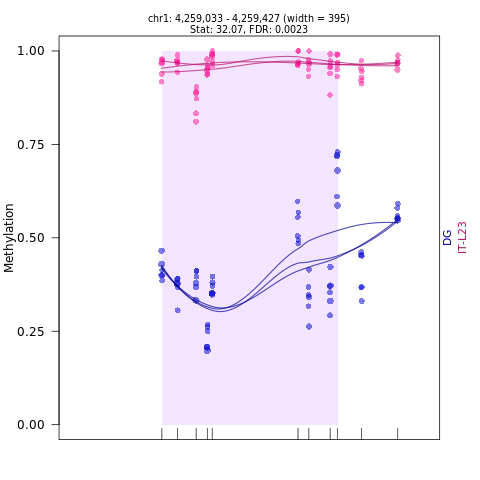

In [18]:
# %%R
# plotDMRs(bs, regions=regions[1,], testCovariate=testCovariate)

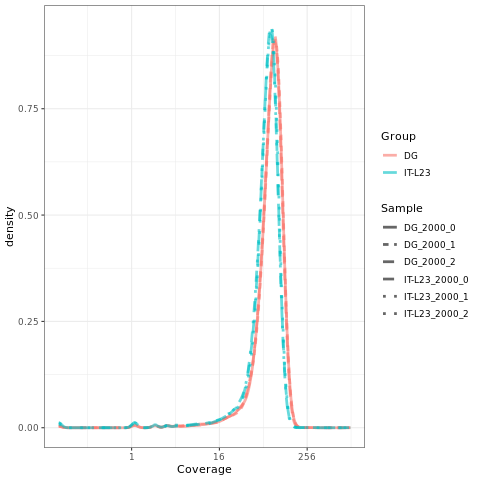

In [31]:
# %%R
# plotEmpiricalDistribution(bs, testCovariate=testCovariate, 
#                           type="Cov", bySample=TRUE)

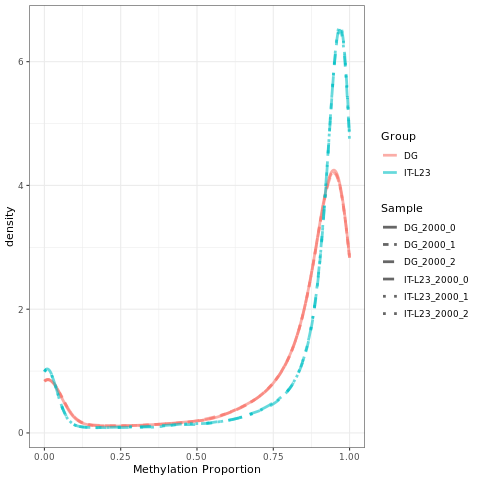

In [32]:
# %%R
# plotEmpiricalDistribution(bs, testCovariate=testCovariate, bySample=TRUE)

```R
Description
Performs a two-step approach that (1) detects candidate regions, and (2) scores candidate regions with an exchangeable (across the genome) statistic and evaluates statistical significance using a permuation test on the pooled null distribution of scores.

Usage
dmrseq(bs, testCovariate, adjustCovariate = NULL, cutoff = 0.1,
  minNumRegion = 5, smooth = TRUE, bpSpan = 1000, minInSpan = 30,
  maxGapSmooth = 2500, maxGap = 1000, verbose = TRUE,
  maxPerms = 10, matchCovariate = NULL, BPPARAM = bpparam(),
  stat = "stat", block = FALSE, blockSize = 5000, chrsPerChunk = 1)
Arguments
bs	
bsseq object containing the methylation values as well as the phenotype matrix that contains sample level covariates

testCovariate	
Character value indicating which variable (column name) in pData(bs) to test for association of methylation levels. Can alternatively specify an integer value indicating which of column of pData(bs) to use. This is used to construct the design matrix for the test statistic calculation. To run using a continuous or categorial covariate with more than two groups, simply pass in the name of a column in 'pData' that contains this covariate. A continuous covariate is assmued if the data type in the 'testCovariate' slot is continuous, with the exception of if there are only two unique values (then a two group comparison is carried out).

adjustCovariate	
an (optional) character value or vector indicating which variables (column names) in pData(bs) will be adjusted for when testing for the association of methylation value with the testCovariate. Can alternatively specify an integer value or vector indicating which of the columns of pData(bs) to adjust for. If not NULL (default), then this is also used to construct the design matrix for the test statistic calculation.

cutoff	
scalar value that represents the absolute value (or a vector of two numbers representing a lower and upper bound) for the cutoff of the single CpG coefficient that is used to discover candidate regions. Default value is 0.10.

minNumRegion	
positive integer that represents the minimum number of CpGs to consider for a candidate region. Default value is 5. Minimum value is 3.

smooth	
logical value that indicates whether or not to smooth the CpG level signal when discovering candidate regions. Defaults to TRUE.

bpSpan	
a positive integer that represents the length in basepairs of the smoothing span window if smooth is TRUE. Default value is 1000.

minInSpan	
positive integer that represents the minimum number of CpGs in a smoothing span window if smooth is TRUE. Default value is 30.

maxGapSmooth	
integer value representing maximum number of basepairs in between neighboring CpGs to be included in the same cluster when performing smoothing (should generally be larger than maxGap)

maxGap	
integer value representing maximum number of basepairs in between neighboring CpGs to be included in the same DMR.

verbose	
logical value that indicates whether progress messages should be printed to stdout. Defaults value is TRUE.

maxPerms	
a positive integer that represents the maximum number of permutations that will be used to generate the global null distribution of test statistics. Default value is 10.

matchCovariate	
An (optional) character value indicating which variable (column name) of pData(bs) will be blocked for when constructing the permutations in order to test for the association of methylation value with the testCovariate, only to be used when testCovariate is a two-group factor and the number of permutations possible is less than 500000. Alternatively, you can specify an integer value indicating which column of pData(bs) to block for. Blocking means that only permutations with balanced composition of testCovariate values will be used (for example if you have samples from different gender and this is not your covariate of interest, it is recommended to use gender as a matching covariate to avoid one of the permutations testing entirely males versus females; this violates the null hypothesis and will decrease power). If not NULL (default), then no blocking is performed.

BPPARAM	
a BiocParallelParam object to specify the parallel backend. The default option is BiocParallel::bpparam() which will automatically creates a cluster appropriate for the operating system.

stat	
a character vector indicating the name of the column of the output to use as the region-level test statistic. Default value is 'stat' which is the region level-statistic designed to be comparable across the genome. It is not recommended to change this argument, but it can be done for experimental purposes. Possible values are: 'L' - the number of loci in the region, 'area' - the sum of the smoothed loci statistics, 'beta' - the effect size of the region, 'stat' - the test statistic for the region, or 'avg' - the average smoothed loci statistic.

block	
logical indicating whether to search for large-scale (low resolution) blocks of differential methylation (default is FALSE, which means that local DMRs are desired). If TRUE, the parameters for bpSpan, minInSpan, and maxGapSmooth should be adjusted (increased) accordingly. This setting will also merge candidate regions that (1) are in the same direction and (2) are less than 1kb apart with no covered CpGs separating them. The region-level model used is also slightly modified - instead of a loci-specific intercept for each CpG in theregion, the intercept term is modeled as a natural spline with one interior knot per each 10kb of length (up to 10 interior knots).

blockSize	
numeric value indicating the minimum number of basepairs to be considered a block (only used if block=TRUE). Default is 5000 basepairs.

chrsPerChunk	
a positive integer value indicating the number of chromosomes per chunk. The default is 1, meaning that the data will be looped through one chromosome at a time. When pairing up multiple chromosomes per chunk, sizes (in terms of numbers of CpGs) will be taken into consideration to balance the sizes of each chunk.

Value
a GRanges object that contains the results of the inference. The object contains one row for each candidate region, sorted by q-value and then chromosome. The standard GRanges chr, start, and end are included, along with at least 7 metadata columns, in the following order: 1. L = the number of CpGs contained in the region, 2. area = the sum of the smoothed beta values 3. beta = the coefficient value for the condition difference (there will be more than one column here if a multi-group comparison was performed), 4. stat = the test statistic for the condition difference, 5. pval = the permutation p-value for the significance of the test statistic, and 6. qval = the q-value for the test statistic (adjustment for multiple comparisons to control false discovery rate). 7. index = an IRanges containing the indices of the region's first CpG to last CpG.

Examples

# load example data 
data(BS.chr21)

# the covariate of interest is the 'CellType' column of pData(BS.chr21)
testCovariate <- 'CellType'

# run dmrseq on a subset of the chromosome (10K CpGs)
regions <- dmrseq(bs=BS.chr21[240001:250000,],
                 cutoff = 0.05,
                 testCovariate=testCovariate)
```